<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Final Project: Earth Analytics Python Course: Spring 2020

Before submitting this assignment, be sure to restart the kernel and run all cells. To do this, pull down the Kernel drop down at the top of this notebook. Then select **restart and run all**.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below.

* IMPORTANT: Before you submit your notebook, restart the kernel and run all! Your first cell in the notebook should be `[1]` and all cells should run in order! You will lose points if your notebook does not run. 

For all plots and code in general:

* Add appropriate titles to your plot that clearly and concisely describe what the plot shows (e.g. time, location, phenomenon).
* Be sure to use the correct bands for each plot.
* Specify the source of the data for each plot using a plot caption created with `ax.text()`.
* Place ONLY the code needed to create a plot in the plot cells. Place additional processing code ABOVE that cell (in a separate code cell).

Make sure that you:

* **Only include the package imports, code, data, and outputs that are CRUCIAL to your homework assignment.**
* Follow PEP 8 standards. Use the `pep8` tool in Jupyter Notebook to ensure proper formatting (however, note that it does not catch everything!).
* Keep comments concise and strategic. Don't comment every line!
* Organize your code in a way that makes it easy to follow. 
* Write your code so that it can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible.
   2. all paths should be created dynamically using the os package to ensure that they work across operating systems. 
* Check for spelling errors in your text and code comments


In [1]:
NAME = "Robina Shaheen"
COLLABORATORS = ""

## Work flow to calculate burn area during Cold Springs fires using multiple satellite data.
**Goal**: Automate Normalized Difference nbr Indices using Landsat, MODIS, multispectral bands without clouds.

1. Import packages required for data processing and plotting.
2. Download data using earthpy and set working directory to earth-analytics.
3. Define pixel values to mask clouds and shadows for each satellite scenes. Define a masking variable to be used later.
4. Define a functions to crop images, produce numpy array, metadata, remove clouds and calculate nbr  values for each image/ scene.
    * i. Context manager will be used in conjunction with the earthpy functions to perform this task.
    * ii. Read and crop quality assurance files that provides information about the clouds and shadows associated with each image.
    * iii. Read and crop all bands needed for the analysis.
    * iv. Used conditional statement to remove clouds as there may be some clear scenes, without any clouds and shadows.
    * v. stack bands and define plotting extents to be used for figures.
    * vi. Calculate ndvi and nbr using Red, NIR and SWIR bands.
5. Define another function to classify the extent of burning such as severe, moderate and low etc.
    
6. Recall function to calculate ndvi and nbr for each image and to store in the list/ dictionary.
8. Recall classification function to classify modis and landsat data.
9. Plot nbr, ndvi, dnbr, dndvi and reclassified data for MODIS, Landsat data. 
10. Compare these images with naip data to understand how differences in the spatial resolution affect the quality of data and imges. 
11. Calculate burned area using Landsat and Modis data.

![Colored Bar](colored-bar.png)

# Week 09 Homework - Multispectral Remote Sensing II


## Include the Plots, Text and Outputs Below

For all plots:

* Add appropriate titles to your plot that clearly and concisely describe what the plot shows.
* Be sure to use the correct bands for each plot.
* Specify the source of the data used for each plot in a plot caption using `ax.text()`.


## Project Introduction (10 points)

Read the overview of the cold springs fire: https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/cold-springs-wildfire/

In the Markdown cell below, add a 2-4 sentence description of the Cold Springs Fire. This should 
include the event:
1. name, 
2. type, 
3. duration / dates and 
4. location. 

The Cold Spring forest fires lasted for ~ two weeks. The fire started on July 09, 2016 and ended on July 24, 2016 in the Nederland, Colorado. The story behind this incident is scrupulous behavior of two campers who left the fire unattended. The high speed winds and low humidity are ideal conditions to spread the fires to larger areas. That's exactly how high winds carried flames farther and dry weather during summer months resulted in huge forest fires causing severe burns over the large area in Cold Springs, Colorado. The fire burned 528 acres, engulfed 8 houses and caused millions of dollars in property losses and ecological damages.

![Colored Bar](colored-bar.png)

In [2]:
# Autograding imports - do not modify this cell
import matplotcheck.notebook as nb
import matplotcheck.autograde as ag
import matplotcheck.raster as rs

In [3]:
# Import libraries (5 points) 
# Only include imports required to run this notebook
 
# YOUR CODE HERE
import warnings
import os
from glob import glob
import re  # regular expressions
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from shapely.geometry import box
warnings.simplefilter('ignore')

# Adjust plot parameters throughout notebook 
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

# # Get Cold Springs fire data
# landsat_data= et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")
# print(landsat_data)

# # Get MODIS data
# modis_data = et.data.get_data('cold-springs-modis-h5')
# print(modis_data)

# Set working directory to 'earth-analytics' and data folder.
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

## Assignment Week 1 - Complete by March 18 

## Define Functions To Process Landsat Data

For next week (March 18), create the 3 functions below used to process landsat data.

For all functions, add a docstring that uses numpy style format (for examples, review the [Intro to Earth Data Sciene textbook chapter on Functions](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/functions-modular-code/write-functions-in-python/#docstring)). 

The docstring should include:

    * A one sentence description of what the function does.
    * Description of each input variable (parameter), following numpy docstring standards.
    * Description of each output object (return), following numpy docstring standards.

## Function 1: crop_stack_data function (5 points)

Write a function called `crop_stack_data` that: 
1. Takes a **list** of raster TIF files and crops all of the files in the list to a given input boundary in GeoPandas GeoDataFrame format.
    * **3 inputs:** 
        * 1) list of files (i.e. the files to crop).
        * 2) directory to export cropped files.
        * 3) GeoPandas GeoDataFrame to crop the data.
2. Returns a stacked **numpy array** of the cropped data and the metadata.
    * **2 outputs:**
        * 1) **numpy array**.
        * 2) **dictionary** containing metadata.

In [4]:
# Add your function here. Do NOT modify the function name
def crop_stack_data(files_to_crop, crop_dir_path, crop_bound):
    """Crops a set of tif files and saves them 
    in a crop directory. Returns a stacked numpy 
    array of bands.
    
    Parameters
    ----------
    files_to_crop : list
        List of paths to multispectrum scenes 
        (.tiff) to be cropped.
    
    crop_dir_path : string
        The path to an output directory.  
        use conditional statment to create one,
        if not in existance. 
        The directory will store, 
        cropped and stacked bands.
        
    crop_bound : gpd (GeoPandas GeoDataFrame)
        Vector shape file geodataframe used for 
        cropping area of interest from the files_to_crop.
    
    Returns
    -------
    all_bands_stack : numpy array(s)
        Stacked and cropped numpy array bands 
        (our new aoi's).
    
    fire_crop_bound : GeoPandas GeoDataFrame
        A vector shape file that either shares 
        the crs of the stacked bands or is 
        reprojected from the crop_bound crs.
    """
    if not os.path.exists(crop_dir_path):
        os.mkdir(crop_dir_path)
        
    # Reproject boundary .shp to geotiff crs 
    with rio.open(files_to_crop[0]) as landsat_src:
        if not crop_bound.crs == landsat_src.crs:
            fire_crop_bound = crop_bound.to_crs(
                                  landsat_src.crs)
            extent = plotting_extent(landsat_src)
#         crop_bound = crop_bound.to_crs(src.crs)
 
    #  crop images using earthpy 
    es.crop_all(raster_paths=files_to_crop,
                output_dir=crop_dir_path,
                geoms= fire_crop_bound,
                overwrite=True)
    
    # Retrieve cropped bands from the new directory
    all_bands = sorted(glob(os.path.join(
                       crop_dir_path, "*.tif")))
    # Stack cropped bands
    all_stack_bands, stack_bands_meta = es.stack(all_bands)
    
    # return cropped, stacked bands and fire boundary
    return all_stack_bands, stack_bands_meta, fire_crop_bound

## Function 2: mask_data (5 points)

In the call below, write a function called `mask_data` that: 
1. Masks a numpy array using the Landsat Cloud QA layer. 
    * **2 inputs:** 
        * 1) numpy array to be masked
        * 2) Landsat QA layer in numpy array format 
2. Returns a masked array. 
    * **1 output:**
        * 1) masked numpy array

In [5]:
# Add your function here. Do NOT modify the function name
def mask_data(arr, path_to_qa):   
    """Function that masks numpy arrays 
    using qa layer.
    
    Parameters
    ----------
    arr : numpy array
        Numpy array(s) of bands of aoi       
    
    path_to_qa : str
        Path to QA layer(s) associated with each band        
    
    Returns
    -------
    arr : masked numpy array
        Updated numpy array(s) of bands with high cloud
        confidence, clouds and cloud shadows masked.        
    """
    # 1. open the qa layer
    with rio.open(path_to_qa[0]) as src:
        mask_arr = src.read(1)
        
    # Cloud mask values
    high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    
    # 2. Mask the numpy array 
    if any(i in np.unique(mask_arr) for i in all_masked_values):
        landsat_masked_bands = em.mask_pixels(landsat_bands,
                                              mask_arr,
                                              vals=all_masked_values)
        return landsat_masked_bands
    else:
        print("There are no pixels to mask")
        return arr

## Function 3: classify_dnbr (5 points)

In the cell below, write a function called `classify_dnbr` that: 
1. Classifies a numpy array using classes/bins defined in the function. 
    * **1 input:**
        * 1) numpy array containing dNBR data in numpy array format 
2. Returns a classified numpy array. 
    * **1 output:**
        * 1) numpy array with classified values (integers)

In [6]:
# Add your function here. Do NOT modify the function name
def classify_dnbr(arr):
    """Function that creates a new numpy array of classified
    values using difference normalized burn ratio (dNBR) as
    numpy array. 
    
    Parameters
    ----------
    arr : Numpy array
        Numpy array(s) containing dNBR data.        
    
    Returns
    -------
    arr_class : Numpy array
        Numpy array(s) containing reclassified 
        dNBR values in 5 possible classes.        
    """

    # YOUR CODE HERE
    # bins to define fire severity
    class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]
    
    # code to classify dnbr values 
    arr_reclass = np.digitize(arr, class_bins)
        
    return arr_reclass

## Assignment Week 2 - BEGINS March 18 

You will write the function below next week after learning more about MODIS h4 data in class on March 18, 2020.

Be sure to add a docstring that uses numpy style format (for examples, review the [Intro to Earth Data Sciene textbook chapter on Functions](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/functions-modular-code/write-functions-in-python/#docstring)). 

The docstring should include:

    * A one sentence description of what the function does.
    * Description of each input variable (parameter), following numpy docstring standards.
    * Description of each output object (return), following numpy docstring standards.
    
## Function 4: stack_modis_bands (10 points)

Write a function called `stack_modis_bands` that: 
1. Loops through an `h4` file to collect and stack all "band" layers in the file.
2. Crops each band to the extent of a given input boundary in GeoPandas GeoDataFrame format.
3. Returns a stacked numpy array of the cropped data and the metadata.

#### Function Inputs and Outputs

1. Takes a path to an h4 file and returns the reflectance bands cropped to a specific extent. 
    * **2 inputs:**
        * 1) string path to hdf h4 file
        * 2) crop_bound in GeoDataFrame format
2. Returns a classified numpy array. 
    * **2 outputs:**
        * 1) numpy array containing cropped MODIS reflectance bands
        * 2) metadata for the numpy array

In [7]:
# # Add your function here. Do NOT modify the function name
# def stack_modis_bands(h4_path, crop_bound):
#     """
#     A function that returns a stacked numpy array of bands, 
#     meta data, plotting extent and fire boundary.
    
#     Parameters:
#     h4_path = a string
#             path to the modis h4 data set
#     crop_bound= geometry/ multipolygon with CRS
#                 shape file describing fire boundary
#     Returns:
#     crop_bands = numpy array
#     crop_meta = meta data
#     modis_extent = plotting extent
#     fire_bound_sin = shape file with CRS   
#     """
#     # Creat an empty list
#     all_bands = []
    
#     # path to dataset and reproject crs
#     with rio.open(h4_path) as dataset:
#         for name in dataset.subdatasets:
#         # get the band
#             if re.search("b0.\_1$", name):
#                 with rio.open(name) as subdataset:
#                     if not crop_bound.crs == subdataset.crs:
#                         fire_bound_sin = crop_bound.to_crs(subdataset.crs)
#                         # crop band using projected fire boundary
#                     crop_band, crop_meta = es.crop_image(
#                         subdataset, fire_bound_sin)
#                         # append the bands as a 2 dim vs 3 dim arr
#                     all_bands.append(np.squeeze(crop_band))

#     # Stack the data and handle no data values
#     crop_bands= np.stack(all_bands)
    
#     # To mask nodata value
#     cleaned_modis_bands= ma.masked_where(
#     crop_bands == crop_meta["nodata"], crop_bands)

#     # define a plotting extent
#     crop_extent = plotting_extent(
#     crop_band[0], crop_meta["transform"]) 
   
#     return cleaned_modis_bands, crop_meta, crop_extent, fire_bound_sin


## Process Landsat Data

In the cells below, open and process your Landsat Data using loops and string manipulation of paths. 

Use the functions `crop_stack_data()` and `mask_data()` that you wrote above to open, 
crop and stack each Landsat data scene (pre and post fire).

#### Notes

If you were implementing this workflow for more scenes, you could write 
a helper function that tested the crs of the crop extent. If it needed to be 
reprojected you could do so and write it out as a file, or store is in a dictionary
for for reuse 
in your loop. For this assignment rather than introducing additional tasks
we will keep it simple and open up and reproject the boundary once.

One way to do this is to create a connection to one single tif file using
rasterio. Once you have the `src` object you can grab the crs and reproject
the fire boundary. The code to do that is below:

```
with rio.open(glob(all_dirs[0] + "/*.tif")[0]) as src:
    fire_bound_utmz13 = fire_boundary.to_crs(src.crs)
```


![Colored Bar](colored-bar.png)

# Figure 1 Overview - Grid of 3 Color InfraRed (CIR) Plots: NAIP, Landsat and MODIS

**You will be able to complete the MODIS subplot after March 18 class!**

Create a single figure that contains a grid of 3 plots of color infrared (also called false color) composite images using:

* Post Fire NAIP data (this is the data that you downloaded for your week 6 homework)
* Post Fire Landsat data (use: `et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")`
* Post Fire MODIS data (use: `et.data.get_data('cold-springs-modis-h5')`

For each map, be sure to:

* Crop the data to the fire boundary extent.
* Overlay the fire boundary layer (`vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp`).
* Use the band combination **r = infrared band**, **g = red band**, **b = green** band.
* Be sure to label each plot with the data type (NAIP vs. Landsat vs. MODIS) and spatial resolution.

HINT: In a CIR image, the NIR band is plotted on the “red” band, the red band is plotted on the "green" band and the green band is plotted on the "blue" band.

In [7]:
# create base path
# all_sites contain path to both sites 
base_path = os.path.join("sd_fires_2014", "sites")

# Define list of directories in "sites"
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
all_sites

['sd_fires_2014\\sites\\BERNARDO\\',
 'sd_fires_2014\\sites\\COCOS\\',
 'sd_fires_2014\\sites\\POINSETTIA\\',
 'sd_fires_2014\\sites\\PULGAS\\',
 'sd_fires_2014\\sites\\TOMAHAWK\\']

In [8]:
# Open fire boundary shape for the landsat data
boundary_path = os.path.join(base_path,
                                "BERNARDO", "vector",
                              "bernardo_box.shp")

# Open a shapefile using geopandas and change CRS.
bernardo_bounds = gpd.read_file(boundary_path)
# sjer_boundary= sjer_bounds.to_crs(epsg=32611)
print(bernardo_bounds.total_bounds)
print(bernardo_bounds.shape)
print(bernardo_bounds.crs)



[ 262667.59617768 -555228.62003459  269261.95448877 -550853.2180618 ]
(1, 2)
{'init': 'epsg:3310'}


In [11]:
# # Create loop to process Landsat data in this cell
# # Setting path to scene directories
# base_path = os.path.join("sd_fires_2014", "sites")
# all_dirs = glob(os.path.join(base_path, "*/"))
# # print(all_dirs)

# Create empty dictionary
# cleaned_landsat_data = {}

# # Get all tif files in the directory
# for scenes in all_dirs:
#     print("path: ", scenes)
# Define list of directories in "sites"
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
all_sites

composite_list = []

# Define the directory name, it is an explicit directory.
landsat_dir = "landsat-crop"

# Loop through each site directory
# first loop to go to harv and sjer direcotry
for site_dir in all_sites:
    
    # Get site name
    site = os.path.basename(os.path.normpath(site_dir)) 
    print(site_dir)
    
    # Define a dynamic boundary path for the site
    boundary_path = os.path.join(site_dir, "vector", 
                                 site + "_box.shp")
    # print(boundary_path)
    boundary = gpd.read_file(boundary_path)
   
    # Get a list of subdirectories for that site
    new_path = os.path.join(site_dir, landsat_dir)
    print("new path:", new_path)
    
    # all dirs is acessing all image directory
    # inner loop iterates on each of these (23)x2 subdirectories.
    all_dirs = glob(new_path + "/*/")  
    all_dirs.sort()
    print("all directories:", all_dirs)

    # Loop through each subdirectory for site
    # the second loop opens tif files
    for dir in all_dirs:
        date = dir[18:25]
        print(date)
        
        # Get all bands in each subdirectory for site
        site_bands = glob(dir + "*.tif")
        site_bands.sort()
        print(site_bands)
        
        # Run function to calculate NDVI for that subdirectory (scene)
        ndvi_clean = open_band_ndvi(bands= 
                            site_bands, site_bounds= fire_boundary)
        composite_list.append([site, ndvi_clean, date])        

# Convert list of values to a data frame
col_names = ["site", "ndvi", "date"]
ndvi_df = pd.DataFrame(composite_list, columns=col_names)
print(ndvi_df)

# Save as csv file
ndvi_df.to_csv(os.path.join("data", "sd_fires_2014", "outputs",
                                "ndvi_df.csv"), header=True)  

#     # Get all tif files in landsat_dir, the directory
#     all_scenes = sorted(glob(os.path.join(scenes, "*.tif")))
#     crop_path = os.path.join(scenes, "cropped")
#     if not os.path.exists(crop_path):
#         os.mkdir(crop_path)
# #     print(crop_path)

#     # Get scenes and date from the landsat_scene
#     landsat_scene = os.path.basename(os.path.normpath(scenes))
#     date = landsat_scene[10:18]
#     print("Landsat image date: ", date)

#     # crop & stack data
#     stacked_bands, stacked_bands_meta, fire_crop_bound = crop_stack_data(
#                                      files_to_crop=all_scenes,
#                                      crop_dir_path=crop_path,
#                                      crop_bound=fire_crop)

#     # Paths to cropped qa and bands
#     cropped_qa = glob(os.path.join(crop_path,
#                                    "*pixel**crop*.tif"))
#     cropped_scenes = sorted(glob(os.path.join(crop_path,
#                                               "*band*")))

#     # Mask all landsat scenes of bad pixels and remove nodata
#     bands_arr, bands_meta = es.stack(cropped_scenes, nodata=-9999)
#     cleaned_landsat_data[date] = mask_data(bands_arr, cropped_qa)

#     # create plotting extent
#     with rio.open(cropped_scenes[3]) as landsat_src:
#         extent = plotting_extent(landsat_src)
        
# print("plotting extent:", extent)
# print("fire cropped boundary CRS:", fire_crop_bound.crs)

sd_fires_2014\sites\BERNARDO\
new path: sd_fires_2014\sites\BERNARDO\landsat-crop
all directories: ['sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\', 'sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat_20140509\\']
s\BERNA
['sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\LC08_L1TP_040037_20140407_20170307_01_T1_pixel_qa.tif', 'sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\LC08_L1TP_040037_20140407_20170307_01_T1_radsat_qa.tif', 'sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\LC08_L1TP_040037_20140407_20170307_01_T1_sr_aerosol.tif', 'sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\LC08_L1TP_040037_20140407_20170307_01_T1_sr_band1.tif', 'sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\LC08_L1TP_040037_20140407_20170307_01_T1_sr_band2.tif', 'sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat_20140407\\LC08_L1TP_040037_20140407_20170307_01_T1_sr_band3.tif', 'sd_fires_2014\\sites\\BER

NameError: name 'open_band_ndvi' is not defined

## Landsat Function Tests

In [10]:
# DO NOT MODIFY - test: crop_stack_data function

In [11]:
# DO NOT MODIFY - test mask_data function


In [12]:
# DO NOT MODIFY - test classify_dnbr function


## Process NAIP Post Fire Data

In the cell below, open and crop the post-fire NAIP data that you downloaded 
for homework 6.

In [13]:
# Process NAIP data
# YOUR CODE HERE

# Import NAIP 2017 image
naip_2017_path = os.path.join("cold-springs-fire", "naip", 
                              "m_3910505_nw_13_1_20170902.tif")

# Use context manager to open.crop, reproject CRS and plotting extent.
with rio.open(naip_2017_path) as naip_2017_src:
    fire_crop_reproj = fire_crop.to_crs('epsg:26913')    
    naip_2017_crop, naip_2017_meta = es.crop_image(
                                     naip_2017_src, 
                                     fire_crop_reproj)
    naip_extent = plotting_extent(naip_2017_crop[0], 
                                  naip_2017_meta['transform'])
print("plotting extent:", naip_extent)
print("naip cropped boundary CRS:", fire_crop_reproj.crs)
# naip_2017_src.crs

plotting extent: (457667.0, 461037.0, 4425145.0, 4426450.0)
naip cropped boundary CRS: epsg:26913


## Process MODIS h4 Data - March 18th, 2020

In the cells below, open and process your MODIS hdf4 data using loops and 
string manipulation of paths. You will learn more about working with MODIS 
in class on March 18th.

Use the function `stack_modis_bands()` that you previously wrote in this notebook to open and crop 
the MODIS data.


In [14]:
# Process MODIS Data
# To access modis directories.
all_modis_dirs = glob(os.path.join('cold-springs-modis-h5', '*'))
# print(all_modis_dirs)

# Create an empty dictionary.
modis_dict = {}

for scene_dir in all_modis_dirs:

    # Get all hdf files in the directory.
    modis_files = sorted(glob(os.path.join(scene_dir, "*.hdf")))
#     print(modis_files)
    # Acquire scene names/ dates
    scene = os.path.basename(os.path.normpath(scene_dir))
    date = (scene)
    print(date)
    
    # Recall function stack_modis_bands
    modis_bands, modis_meta, modis_extent, modis_fire_bound  = stack_modis_bands(
                                    h4_path = modis_files[0], 
                                    crop_bound = fire_crop)
    
    # Creating dictionary
    modis_dict[date] = np.squeeze(modis_bands)

#     modis_dict[date] = {
#         'ndvi': es.normalized_diff(modis_bands[1], modis_bands[0]),
#         'nbr' : es.normalized_diff(modis_bands[1], modis_bands[6])}

07_july_2016
17_july_2016


In [15]:
# DO NOT MODIFY THIS CELL - autograding tests for MODIS function stack_modis_bands


## Figure 1: Plot CIR for NAIP, Landsat and MODIS Using Post Fire Data (15 points each subplot)

In the cell below, create a figure with 3 subplots stacked vertically.

In each subplot, plot a CIR composite image using the post-fire data for:

* NAIP  (first figure axis) 
* Landsat (second figure axis) 
* MODIS (third figure axis)

respectively on this figure.

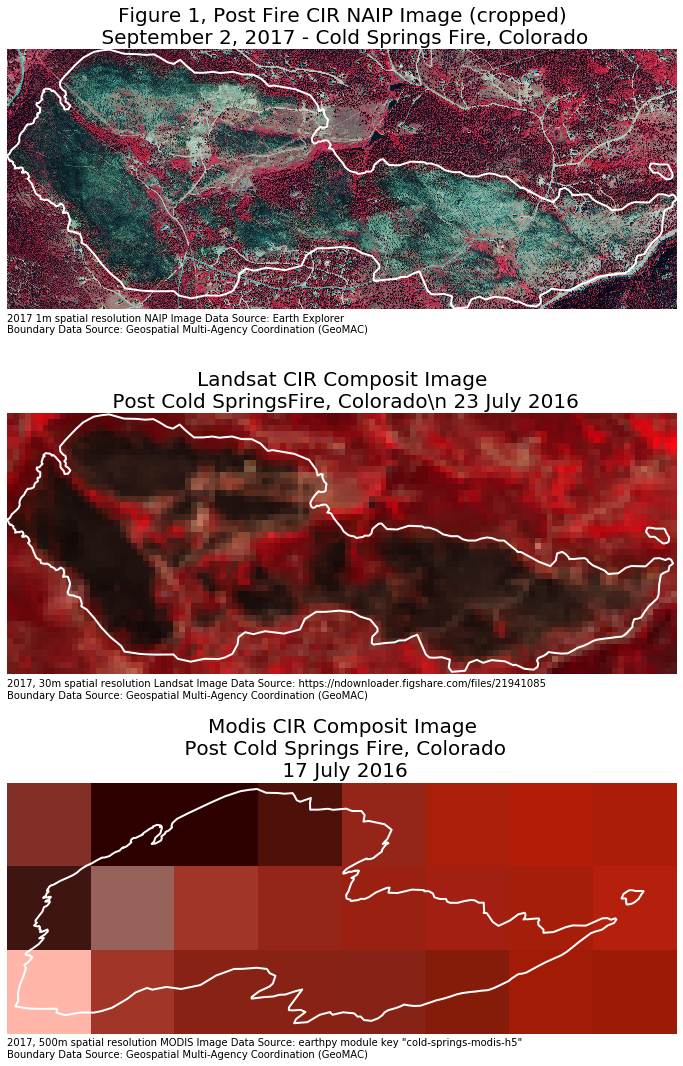

In [16]:
# Plot CIR of Post Fire NAIP, Landsat & MODIS together in one figure
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12, 19))
offset=-.03
# # Define main figure caption
# fig.suptitle(
#     "Figure 1, Grid of three color Infra Red (CIR) Post-Fire Plots", 
#     fontsize=20)

# Plot NAIP images required for homework
ep.plot_rgb(naip_2017_crop,
            extent=naip_extent,
            rgb=[3, 0, 1],
            ax=ax1,
            title="Figure 1, Post Fire CIR NAIP Image (cropped)\n "
                  r"September 2, 2017 - Cold Springs Fire, Colorado")
fire_crop_reproj.plot(ax=ax1, color='None',
                      edgecolor='white', linewidth=2)
# Plot Landsat CIR
ep.plot_rgb(cleaned_landsat_data["20160723"],
            rgb=[4, 3, 2],
            extent=extent,
            ax=ax2,
            title="Landsat CIR Composit Image\n Post Cold Springs"
            r"Fire, Colorado\n 23 July 2016")
fire_crop_bound.plot(ax=ax2, color="None",
                     edgecolor="white", linewidth=2)
# Plot modis CIR
ep.plot_rgb(modis_dict['17_july_2016'],
            rgb=[4, 3, 2],
            extent=modis_extent,
            ax=ax3,
            title="Modis CIR Composit Image\n Post Cold Springs"
            " Fire, Colorado\n 17 July 2016")

modis_fire_bound.plot(ax=ax3, color="None",
                      edgecolor="white", linewidth=2)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# Define figure captions and text alignment.
ax1.text(0, -0.1, '2017 1m spatial resolution NAIP Image Data Source: Earth Explorer\n'
         r'Boundary Data Source: Geospatial Multi-Agency '
         r'Coordination (GeoMAC)', verticalalignment='bottom',
         horizontalalignment='left', transform=ax1.transAxes)

ax2.text(0, -0.1, '2017, 30m spatial resolution Landsat Image Data Source: '
         'https://ndownloader.figshare.com/files/21941085\n'
         r'Boundary Data Source: Geospatial Multi-Agency '
         r'Coordination (GeoMAC)', verticalalignment='bottom',
         horizontalalignment='left', transform=ax2.transAxes)

ax3.text(0, -0.1, '2017, 500m spatial resolution MODIS Image Data Source: earthpy '
         'module key "cold-springs-modis-h5" \n'
         r'Boundary Data Source: Geospatial Multi-Agency '
         r'Coordination (GeoMAC)', verticalalignment='bottom',
         horizontalalignment='left', transform=ax3.transAxes)
### DO NOT REMOVE LINE BELOW ###
plot01_CIR_res_comparison = nb.convert_axes(plt, which_axes="all")

In [17]:
# DO NOT TOUCH THIS CELL - autograding tests for NAIP subplot


In [18]:
# DO NOT TOUCH THIS CELL - autograding tests for Landsat subplot


In [19]:
# DO NOT TOUCH THIS CELL - autograding tests for MODIS subplot


![Colored Bar](colored-bar.png)

# Figure 2: Difference NDVI (dNDVI) Using Landsat & MODIS Data (20 points each subplot)

Plot the NDVI difference using before and after Landsat and MODIS data 
that cover the Cold Springs Fire study area. For each axis be sure to:

1. overlay the fire boundary (`vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp`) on top of the data.
2. Be sure that the data are cropped using the fire boundary extent.

In the cell below, create a figure with 2 subplots stacked vertically:
* Plot dNDVI for Landsat on the first axis of the figure.
* Plot dNDVI using MODIS on the second axis of the figure.

Use the "before" and "after" data that you processed above to calculate NDVI difference for both MODIS and Landsat


## NDVI Difference

To create the NDVI Difference raster using "before" and "after" fire 
Landsat and MODIS data, you must first calculate NDVI for each 
dataset "before" and "after" the fire. 

Once you have the "before" and "after" NDVI arrays, you can subtract 
the pre-fire NDVI array FROM the post-fire NDVI array (post-fire minus pre-fire). 

The resulting array will show you change in the area's NDVI from the first image to the second image.

HINT: Remember, you can use `es.normalized_diff(band_1, band_2)` to get the NDVI of an image. 

In [20]:
# Pre and postfire and the difference between two NDVI
landsat_prefire_ndvi = es.normalized_diff(
    cleaned_landsat_data["20160621"][4],
    cleaned_landsat_data["20160621"][3])
landsat_postfire_ndvi = es.normalized_diff(
    cleaned_landsat_data["20160723"][4],
    cleaned_landsat_data["20160723"][3])
landsat_dndvi = landsat_postfire_ndvi - landsat_prefire_ndvi
print(landsat_dndvi)

[[-0.005923310129505532 0.060774509817594025 0.03263341998623748 ...
  0.0316263147723822 0.027509811577992926 0.03359678706588054]
 [0.10700961902644124 0.06889376482685472 -0.02733924074553351 ...
  -0.0014040079529353822 -0.026625406294563114 -0.06127550691368744]
 [0.029936417260360892 0.018962157203522012 0.021052151955294085 ...
  0.0029696460590925566 0.03870643236460469 0.03195617939061968]
 ...
 [0.015140813919736873 -0.00031077764274234365 0.11821236559139792 ...
  0.03011591709674777 0.07885741265677881 0.05896689959091228]
 [0.0431430524865985 0.05208889277991691 0.040794394572190584 ...
  0.024289334336853097 0.03621088754714541 0.03747398884304215]
 [0.026193438862403495 0.06297039097711926 0.04920372066802903 ...
  0.03283406470392325 0.04698955718756781 0.017005606660189077]]


In [21]:
# Calculate prefire and post fire modis NDVI and difference.
modis_prefire_ndvi = es.normalized_diff(
    modis_dict['07_july_2016'][1], 
    modis_dict['07_july_2016'][0])
modis_postfire_ndvi = es.normalized_diff(
    modis_dict['17_july_2016'][1], 
    modis_dict['17_july_2016'][0])

# Calculate MODIS dnbr as pre - post fire nbr and divide into five classes 
modis_dndvi = modis_postfire_ndvi - modis_prefire_ndvi
print(modis_dndvi)

[[-0.3672351060738157 -0.26828611366813265 -0.26828611366813265
  -0.3901515151515152 -0.3457548091006738 -0.12835125105317757
  -0.12123415607551946 -0.1053681064678581]
 [-0.48221614227086185 -0.550037273721943 -0.35859374271403766
  -0.32402434658073753 -0.20142694654120563 -0.21446916259721466
  -0.19222764964038863 -0.14415339451399622]
 [-0.5682159069519738 -0.35859374271403766 -0.28748388543243086
  -0.28748388543243086 -0.348066836401074 -0.22881672265770808
  -0.09165577986083961 -0.09056133440019698]]


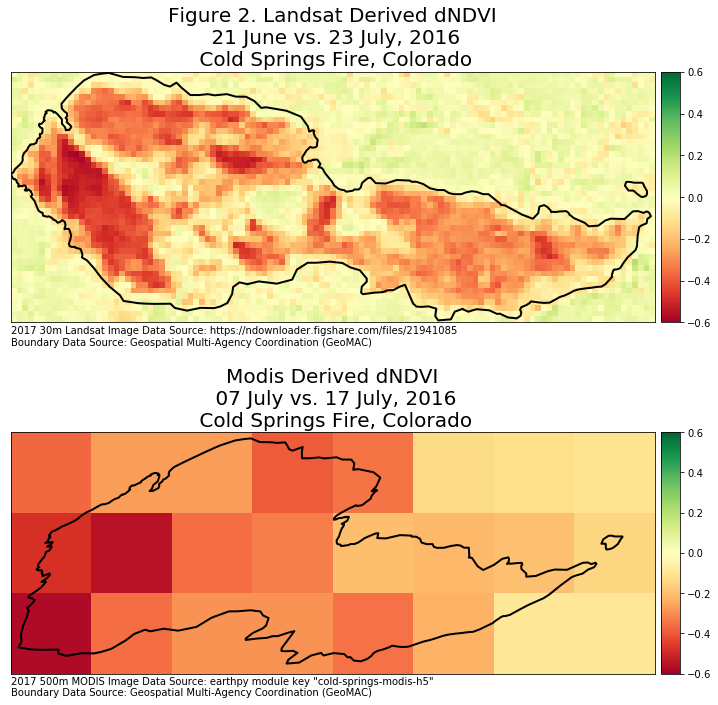

In [22]:
# Plot Difference NDVI for Landsat & MODIS together in one figure
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 12))

# Plot Landsat dNDVI
ep.plot_bands(landsat_dndvi, cmap="RdYlGn",
              vmin=-0.6, vmax=0.6, ax = ax1, extent=extent,
              title="Figure 2. Landsat Derived dNDVI\n 21 June vs. 23 July," \
                    " 2016\n Cold Springs Fire, Colorado", scale=False)

fire_crop_bound.plot(ax=ax1, color='None', 
                      edgecolor='black', linewidth=2)

# Plot modis dNDVI
ep.plot_bands(modis_dndvi, cmap="RdYlGn",
              vmin=-0.6, vmax=0.6, ax = ax2, extent=modis_extent,
              title="Modis Derived dNDVI\n 07 July vs. 17 July," \
                    " 2016\n Cold Springs Fire, Colorado", scale=False)

modis_fire_bound.plot(ax=ax2, color='None', 
                    edgecolor='black', linewidth=2)

# Figure captions
ax1.text(0, -0.1, '2017 30m Landsat Image Data Source: ' \
         'https://ndownloader.figshare.com/files/21941085\n' 
         r'Boundary Data Source: Geospatial Multi-Agency ' \
         r'Coordination (GeoMAC)', verticalalignment='bottom',  
         horizontalalignment='left', transform=ax1.transAxes)

ax2.text(0, -0.1, '2017 500m MODIS Image Data Source: earthpy ' \
         'module key "cold-springs-modis-h5" \n'
         r'Boundary Data Source: Geospatial Multi-Agency ' \
         r'Coordination (GeoMAC)', verticalalignment='bottom',  
         horizontalalignment='left', transform=ax2.transAxes)

### DO NOT REMOVE LINE BELOW ###
plot02_landsat_modis_ndvi_diff = nb.convert_axes(plt, which_axes="all")

In [23]:
# Ignore this cell - autograding tests for Landsat subplot


In [24]:
# Ignore this cell - autograding tests for MODIS subplot


![Colored Bar](colored-bar.png)

# Figure 3 Overview: Difference NBR (dNBR) Using Landsat  & MODIS Data (25 points each subplot)

Create a figure that has two subplots stacked vertically using the same MODIS and Landsat data that you processed above. 

* Subplot one: classified dNBR using Landsat data
* Subplot two: classified dNBR using MODIS data 

For each subplot, overlay the fire extent boundary `vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp`
on top of the dNBR map

To classify each dNBR raster, use the `classify_dnbr()` function that you 
defined above. 

When you plot your MODIS data, you may notice that the data does not contain all of the classes that Landsat contains which can range from 1-5. To ensure that your colormap plots properly, set the `vmin=` and `vmax=` parameters to 1 and 5 respectively when you call `ep.plot_bands()`:

`vmin=1, vmax=5`


## Figure Legend

You only need one legend for this figure. The `ep.draw_legend()` function will create a legend of "boxes" if you provide it with an:

1. `imshow()` image object
2. classes : a list of numbers that represent the classes in your numpy array
3. titles: a list of dNBR class names example: `["High Severity", "Low Severity"]`

### dNBR Classes

Note: if you scaled your data, you may need to scale the values below by a factor of 10.

| SEVERITY LEVEL  | dNBR RANGE |
|----------------|--------------|
| Enhanced Regrowth | < -.1 |
| Unburned        | -.1 to +.1 |
| Low Severity     | +.1 to +.27 |
| Moderate Severity  | +.27 to +.66 |
| High Severity    | > .66 |


HINT: Your dNBR classification list should look like this:
`[-np.inf, -.1, .1, .27, .66, np.inf]`

HINT 2: If you want to use them, these are the colors used in the maps on the website:

`["g", "yellowgreen", "peachpuff", "coral", "maroon"]`

The code to create a custom colormap for the plot is below:

```
nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)
```

In [25]:
# Calculate dNBR for Landsat - be sure to use the correct bands!
# Landsat NBR processing
landsat_prefire_nbr = es.normalized_diff(
    cleaned_landsat_data["20160621"][4],
    cleaned_landsat_data["20160621"][6])
landsat_postfire_nbr = es.normalized_diff(
    cleaned_landsat_data["20160723"][4],
    cleaned_landsat_data["20160723"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr - landsat_postfire_nbr
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
print(landsat_dnbr_reclass)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [26]:
# Calculate dNBR for MODIS - be sure to use the correct bands!
# MODIS Pre, post, difference between NBRs and classification
modis_prefire_nbr = es.normalized_diff(
    modis_dict['07_july_2016'][1], modis_dict['07_july_2016'][6])
modis_postfire_nbr = es.normalized_diff(
    modis_dict['17_july_2016'][1], modis_dict['17_july_2016'][6])

modis_dnbr = modis_prefire_nbr - modis_postfire_nbr
modis_dnbr_reclass = classify_dnbr(modis_dnbr)
print(modis_dnbr_reclass)

[[3 2 2 4 4 3 3 3]
 [3 4 4 4 3 4 3 3]
 [4 4 4 4 4 4 3 3]]


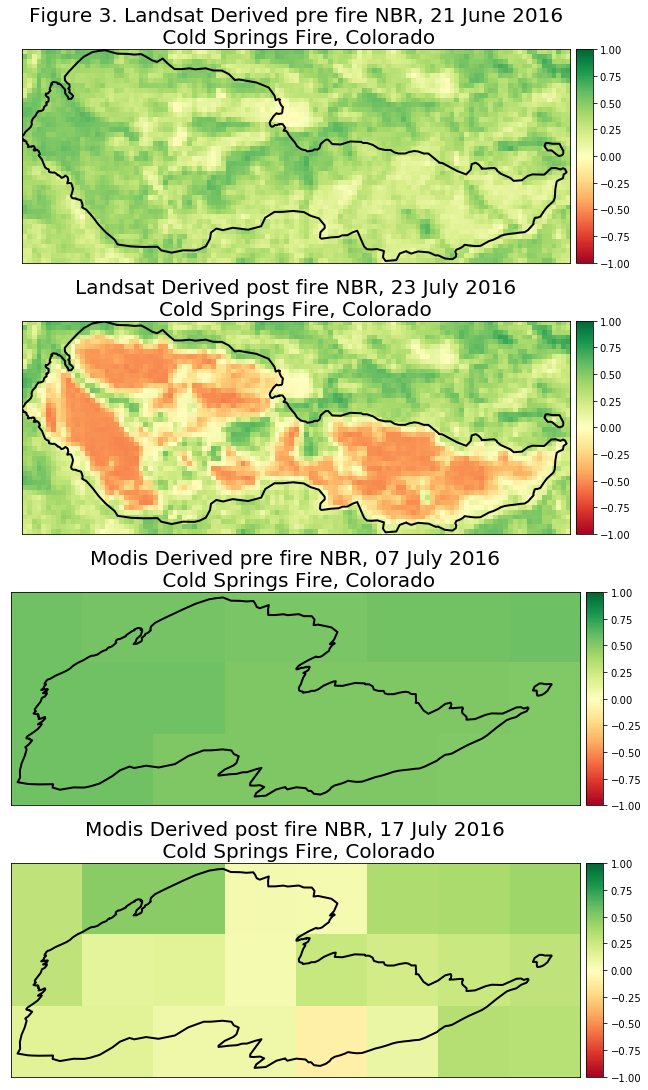

In [27]:
# Define color pallets
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]

cmap = ListedColormap(colors)

# Plot pre, post NBR
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1,
                                         figsize=(10, 15), constrained_layout=True)
# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title="Figure 3. Landsat Derived pre fire NBR, 21 June 2016\n " +
                    "Cold Springs Fire, Colorado")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="Landsat Derived post fire NBR, 23 July 2016\n" +
                    "Cold Springs Fire, Colorado")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)

# MODIS pre and post fire NBR
ep.plot_bands(modis_prefire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax3, extent=modis_extent,
              title="Modis Derived pre fire NBR, 07 July 2016\n " +
                    "Cold Springs Fire, Colorado", scale=False)
modis_fire_bound.plot(ax=ax3, color='None', edgecolor='black', linewidth=2)

ep.plot_bands(modis_postfire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax4, extent=modis_extent,
              title="Modis Derived post fire NBR, 17 July 2016\n " +
                    "Cold Springs Fire, Colorado", scale=False)
modis_fire_bound.plot(ax=ax4, color='None', edgecolor='black', linewidth=2)

plt.show()

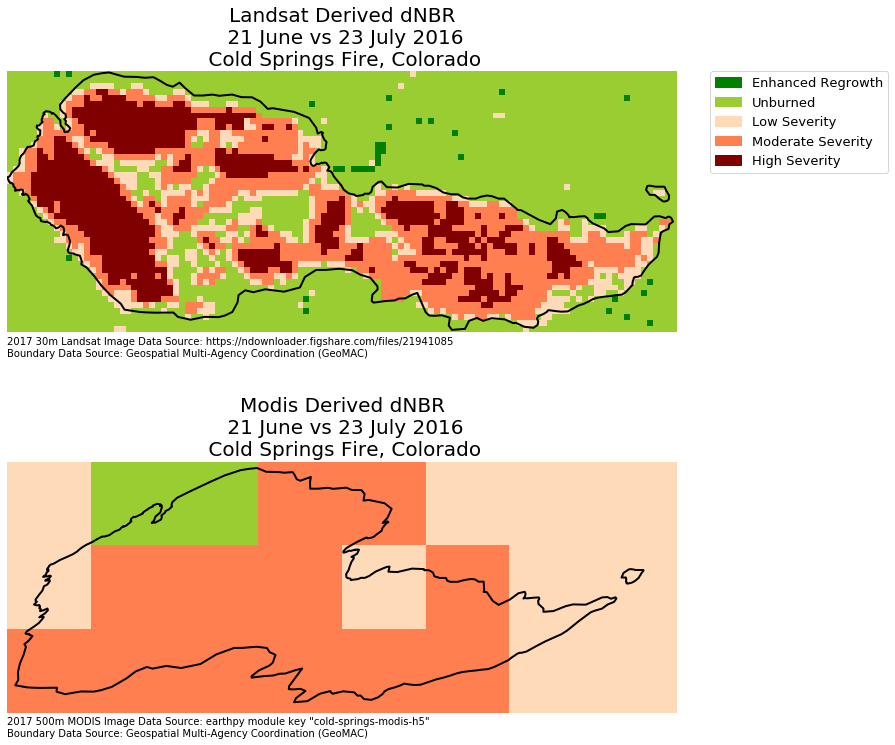

In [28]:
# Reclassified difference in NBR (dNBR) for Landsat & MODIS together in one figure

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 13))

colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
               "Moderate Severity", "High Severity"]
cmap = ListedColormap(colors)

# Plot Landsat dNBR
im = ax1.imshow(landsat_dnbr_reclass, cmap = cmap, 
                extent=extent)

fire_crop_bound.plot(ax=ax1, color='None', 
                      edgecolor='black', linewidth=2)

ep.draw_legend(im, titles=class_labels)
ax1.set_title("Landsat Derived dNBR\n 21 June vs 23 July " \
          "2016\n Cold Springs Fire, Colorado")
ax1.set_axis_off()

# Plot Modis dNBR
im2 = ax2.imshow(modis_dnbr_reclass, cmap = cmap, 
                vmin=1, vmax=5, extent=modis_extent)

modis_fire_bound.plot(ax=ax2, color='None', 
                    edgecolor='black', linewidth=2)

ax2.set_title("Modis Derived dNBR\n 21 June vs 23 July " \
              "2016\n Cold Springs Fire, Colorado")
ax2.set_axis_off()

# Captions
ax1.text(0, -0.1, '2017 30m Landsat Image Data Source: ' \
         'https://ndownloader.figshare.com/files/21941085\n' 
         r'Boundary Data Source: Geospatial Multi-Agency ' \
         r'Coordination (GeoMAC)', verticalalignment='bottom',  
         horizontalalignment='left', transform=ax1.transAxes)

ax2.text(0, -0.1, '2017 500m MODIS Image Data Source: earthpy ' \
         'module key "cold-springs-modis-h5" \n'
         r'Boundary Data Source: Geospatial Multi-Agency ' \
         r'Coordination (GeoMAC)', verticalalignment='bottom',  
         horizontalalignment='left', transform=ax2.transAxes)

### DO NOT REMOVE LINE BELOW ###
plot03_landsat_dnbr = nb.convert_axes(plt, which_axes="all")

In [29]:
# Ignore this cell - autograding tests for Landsat subplot


In [30]:
# Ignore this cell - autograding tests for MODIS subplot


![Colored Bar](colored-bar.png)

# Landsat vs MODIS  Burned Area (10 points)

In the cell below, print the total area burned in classes 4 and 5 (moderate to high severity) for both datasets 
(Landsat and MODIS).

HINT: Feel free to experiment with loops to complete this part of the homework. 

In [31]:
# Total Burned Area in Classes 4 and 5 for Landsat and MODIS
landsat_pixel_area = int(landsat_src.res[0]) * int(landsat_src.res[0])
modis_pixel_area = int(modis_meta['transform'][0]) * \
    int(modis_meta['transform'][0])

# Lists for dnbr reclassed data and the two areas calculated above.
burned_area_per_source = [landsat_dnbr_reclass, modis_dnbr_reclass]
burned_area_per_pixel = [landsat_pixel_area, modis_pixel_area]

landsat_class_4 = (landsat_dnbr_reclass[landsat_dnbr_reclass == 4]).size
landsat_class_5 = (landsat_dnbr_reclass[landsat_dnbr_reclass == 5]).size

modis_class_4 = (modis_dnbr_reclass[modis_dnbr_reclass == 4]).size
modis_class_5 = (modis_dnbr_reclass[modis_dnbr_reclass == 5]).size

landsat_mod_severity_area = landsat_pixel_area * landsat_class_4
landsat_high_severity_area = landsat_pixel_area * landsat_class_5

landsat_total_burn_area = landsat_mod_severity_area + landsat_high_severity_area

modis_mod_severity_area = modis_pixel_area * modis_class_4
modis_high_severity_area = modis_pixel_area * modis_class_5

modis_total_burn_area = modis_mod_severity_area + modis_high_severity_area

print('Landsat total burned area:',
      landsat_total_burn_area, 'square meter')
print('Modis total burned area:',
      modis_total_burn_area, 'square meter')

Landsat total burned area: 1543500 square meter
Modis total burned area: 2572428 square meter


# Conclusions
The Normalized Burn Ratio is a powerful tool to understand the fire extent (area burned) and severity of fire. It is calculated as the difference between pre and post fire conditions. The term “severity” is a qualitative term that can be quantified in different ways. 
Our data analysis using no of classified pixels at different severity indices indicates that the spatial resolution is an important parameter in calculating area burned during the Cold Springs fires, Colorado in July 2017.
The low spatial resolution of MODIS satellite (500m) compared to the Landsat (30m) yielded twice burned area.

![Colored Bar](colored-bar.png)

# Do not edit this cell! (5 points)

* Each figure specifies the source of the data (for each plot) using a plot caption created with `ax.text()`.

# Do not edit this cell! (5 points)

The notebook will also be checked for overall clean code requirements as specified at the **very top** of this notebook! Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

# Do not edit this cell!  (5 points)

All functions contain docstrings with inputs and outputs clearly identified and following numpy docstring standards.